In [1]:
import init
import utils

import bs4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from striprtf.striprtf import rtf_to_text
from IPython.display import display_markdown

import re
from zoneinfo import ZoneInfo

In [2]:
DATA_REPORTS_PATH = '../data/RTVSlo/Podatki - rtvslo.si/**/*.rtf'
DATA_PROMET_SI_PATH = '../data/RTVSlo/Podatki - PrometnoPorocilo_2022_2023_2024.xlsx'

## Loading and Parsing the Data

The functions for loading and parsing the data are defined in the `utils.data` module.
Here, we only invoke them.

In [5]:
df_reports = utils.data.load_traffic_reports(DATA_REPORTS_PATH)
df_promet = utils.data.load_promet_si(DATA_PROMET_SI_PATH)

Loading cached DataFrame from c:\Users\janez\FRI\data-science\semester-2\NLP\Project\utils\../data/parsed/traffic_reports.csv


## Further Data Cleaning

Most irrelevant documents have already been removed in the parsing step, since
only the documents for which dates and timestamps were properly extracted were kept.
However, we still apply additional cleaning steps to find and remove any remaining
irrelevant documents.

To do this, we embed the documents using a `SloBERTa` model which was fine-tuned for
topic classification.

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


def embed_texts(texts: list[str], model_name = 'cjvt/sloberta-trendi-topics'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    embeddings = []
    predictions = []

    for i, text in enumerate(texts):
        print(f'Embedding text {i+1} of {len(texts)}', end='\r')
        inputs = tokenizer(text, return_tensors='pt', truncation=True)

        with torch.no_grad():
            output = model(**inputs, output_hidden_states=True)
            emb = output.hidden_states[-1].squeeze(0).mean(dim=0)
            probs = torch.nn.functional.softmax(output.logits, dim=-1)
        
        embeddings.append(emb.numpy().ravel())
        predictions.append(probs.numpy().ravel())

    return embeddings, predictions


@utils.cache.npz('../data/cache/report_embeddings.npz')
def embed_reports(df_reports: pd.DataFrame):
    texts = df_reports['text'].tolist()
    embeddings, predictions = embed_texts(texts)
    return embeddings, predictions

c:\Users\janez\miniconda3\envs\nlp-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we take two known irrelevant reports to do a sanity check of our data cleaning process. One of these reports is
a weather report and the other is a irrelevant opinion piece. In addition to these two reports, we will compare three
reports which are known to be relevant traffic reports.

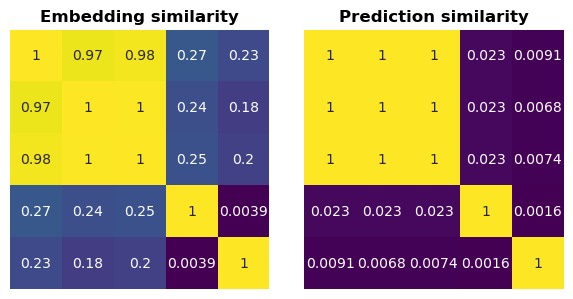

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

paths_bad = [
    '../data/RTVSlo/Podatki - rtvslo.si/Promet 2024/Julij 2024/TMP7-2024-626.rtf',
    '../data/RTVSlo/Podatki - rtvslo.si/Promet 2024/April 2024/TMP4-2024-519.rtf'
]

texts_bad = [utils.data._read_one_traffic_report(path) for path in paths_bad]
texts_good = df_reports['text'].tolist()[:3]
texts = texts_good + texts_bad

embeddings, predictions = embed_texts(texts)
embedding_sims = cosine_similarity(embeddings)
prediction_sims = cosine_similarity(predictions)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].set_title('Embedding similarity', fontweight='bold')
axs[1].set_title('Prediction similarity', fontweight='bold')
sns.heatmap(embedding_sims, ax=axs[0], cmap='viridis', annot=True, cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(prediction_sims, ax=axs[1], cmap='viridis', annot=True, cbar=False, square=True, xticklabels=False, yticklabels=False)
fig.tight_layout()

True reports appear to be more similar to each other than to the irrelevant reports. We
now compute the embeddings on the entire dataset.

In [8]:
embeddings, predictions = embed_reports(df_reports)

# Only compare each report to a subset of reports to speed up the process
sample_size = 1000
sample_indices = np.random.choice(len(embeddings), sample_size, replace=False)
embeddings_ref = embeddings[sample_indices]
predictions_ref = predictions[sample_indices]

embedding_sims = cosine_similarity(embeddings, embeddings_ref)
embedding_sims_mean = np.mean(embedding_sims, axis=1)

Loading cached numpy arrays from ../data/cache/report_embeddings.npz


In [9]:
idx = np.argsort(embedding_sims_mean)
for i in idx[:3]:
    print(f'--- Report {i} (mean similarity = {embedding_sims_mean[i]:.3f}) ---')
    print(df_reports.iloc[i].text[:500] + ' ...\n')

--- Report 7082 (mean similarity = 0.309) ---
30.09.2022 11.00 sta, reuter, surs/bp, tp, gb		
Ura je 11.00.	
							F-2
	Cene življenjskih potrebščin so se septembra na letni ravni zvišale za desetino, na mesečni pa znižale za skoraj odstotek. K letni inflaciji so najbolj prispevale višje cene prehrambnih izdelkov. Hrana in brezalkoholne pijače so se v enem letu podražile za 14,4 odstotka. Na mesečno deflacijo pa je najbolj vplivala pocenitev električne energije za skoraj četrtino, kar je posledica vladne regulacije cen. S statističnega ura ...

--- Report 11691 (mean similarity = 0.330) ---
Nujna prometna informacija   	   25. 03. 2023        14.48                 2. program

Nujna prometna informacija.

Zaradi prometnih nesreč je promet oviran:
-	na vipavski hitri cesti proti Vrtojbi med pokritim vkopom Rebrnice 2 in predorom Barnica ter
-	na avtocestnem odseku od Fernetičev proti Gabrku med počivališčem Povir in razcepom Gabrk.

Na vipavski hitri cesti med pokritim vkopom Rebrnice 2

One report does not seem to be a traffic report, so we remove it from the dataset.

In [10]:
i_to_remove = 7082
df_reports = df_reports.drop(i_to_remove).reset_index(drop=True)

## Removing Empty Reports

Some reports contain a valid header with a date and time, but no text. By visually inspecting
short reports, we found that all reports with less than 40 characters are empty. We remove these
here.

In [11]:
mask = df_reports.content.str.len() <= 40
removed_rows = df_reports[mask].content.to_frame().copy()
df_reports = df_reports[~mask].reset_index(drop=True)
removed_rows

,content
17787,Podatki o prometu.\n
19699,Podatki o prometu.\n
22759,Podatki o prometu:\n
23272,Podatki o prometu\n
23484,Podatki o prometu\n


## Merging the Input (*promet.si*) and Output (*reports*) Data

In [12]:
def html_to_text(html_content: str) -> str:
    if pd.isna(html_content):
        return html_content

    soup = bs4.BeautifulSoup(html_content, 'html.parser')
    block_tags = {'p', 'div', 'br', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'li', 'ul', 'ol', 'table', 'tr', 'td', 'blockquote', 'section', 'article'}

    # Insert newlines after specific tags
    for tag in soup.find_all():
        if tag.name in block_tags:
            tag.append('\n')

    text = soup.get_text()
    lines = [line.strip() for line in text.splitlines()]
    text_clean = '\n'.join(lines)
    return text_clean

In [13]:
@utils.cache.csv('../data/parsed/reports_promet_merged.csv')
def merge_reports_and_promet(df_reports: pd.DataFrame, df_promet: pd.DataFrame, merge_window = pd.Timedelta(minutes=30), merge_entries_max = 10):
    promet_cols_map = {
        'LegacyId': 'info_id',
        'Datum': 'info_datetime',
        'A1': 'info_aggregated_urgent',
        'B1': 'info_aggregated_basic',
        'ContentPomembnoSLO': 'info_urgent',
        'ContentNesreceSLO': 'info_accidents',
        'ContentZastojiSLO': 'info_jams',
        'ContentVremeSLO': 'info_weather',
        'ContentOvireSLO': 'info_obstacles',
        'ContentDeloNaCestiSLO': 'info_roadworks',
        'ContentOpozorilaSLO': 'info_warnings',
        'ContentSplosnoSLO': 'info_basic',
    }

    report_cols_map = {
        'datetime': 'report_datetime',
        'type': 'report_type',
        'path': 'report_path',
        'content': 'report_content'
    }

    promet_cols = list(promet_cols_map.values())
    promet_cols_txt = [p for p in promet_cols if p not in {'info_id', 'info_datetime'}]

    report_cols = list(report_cols_map.values())
    report_cols_og = list(report_cols_map.keys())

    df_reports_promet_list = []
    for i, report in df_reports.iterrows():
        print(f'Merging report {i+1} of {len(df_reports)}', end='\r')
        report_time = report['datetime']
        
        # Select up to <merge_entries_max> most recent entries from df_promet that are within <merge_window> of the report time
        timestamp_diff = (df_promet['Datum'] - report_time).abs()
        timestamp_diff = timestamp_diff[df_promet['Datum'] <= report_time]
        timestamp_diff = timestamp_diff[timestamp_diff <= merge_window]
        timestamp_diff = timestamp_diff.sort_values()
        
        # Format the selected entries and merge them with the report
        df_promet_cur = df_promet.loc[timestamp_diff.index].copy()
        df_promet_cur[report_cols] = report[report_cols_og].values
        df_promet_cur = df_promet_cur.rename(columns=promet_cols_map)
        df_promet_cur = df_promet_cur.rename(columns=report_cols_map)

        # Some entries have the same content - remove duplicates
        df_promet_cur = df_promet_cur.drop_duplicates(subset=promet_cols_txt, keep='first')
        df_promet_cur = df_promet_cur.head(merge_entries_max)

        df_promet_cur = df_promet_cur[report_cols + promet_cols]
        df_promet_cur.insert(0, 'report_id', i)

        # Convert HTML content to text
        for col in promet_cols_txt:
            df_promet_cur[col] = df_promet_cur[col].apply(html_to_text)
        df_reports_promet_list.append(df_promet_cur)

    df_merged = pd.concat(df_reports_promet_list, ignore_index=True)
    return df_merged

In [14]:
df_merged = merge_reports_and_promet(df_reports, df_promet)
n_reports_prev = len(df_reports)
n_reports_merged = df_merged['report_id'].nunique()

msg = f'{n_reports_prev} traffic reports were reduced to **{n_reports_merged} reports after merging**.'
display_markdown(msg, raw=True)

27561 traffic reports were reduced to **25415 reports after merging**.

## Deduplication

Later, we also noticed that some reports have the same date and timestamp, but differ
in their content. We have yet to decide how to handle such cases, i.e. which of these
reports to keep.

In [19]:
stamp_counts = df_reports.datetime.value_counts()
stamp_counts = stamp_counts[stamp_counts > 1]
stamp_counts = stamp_counts.sort_values(ascending=False)
stamp_counts.value_counts().to_frame(name='Number of duplicate sets')

,Number of duplicate sets
count,
2,2456
3,89
4,18
6,1


As seen above, there are **2456** pairs of reports with the same date and timestamp.
There are also some instances where the same timestamp is shared by more than two reports.

In [ ]:
# TODO: Handle such cases